# Data and libraries import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# 'multi_output': One model predicts all 3 coefficients (cl, cd, cm) at once.
# 'single_output': Three separate models are trained, each for a single coefficient.
MODEL_TYPE = 'single_output'

# Import the CSV file containing the DeepLearWing dataset.
# We assume the data file is named 'DeepLearWing.csv' and is in the same directory.
try:
    df = pd.read_csv('DeepLearWing.csv')
    print("Data file loaded successfully.")
except FileNotFoundError:
    print("Error: 'DeepLearWing.csv' not found.")
    print("Please make sure the file is in the correct directory and with proper name.")
    sys.exit()

Data file loaded successfully.


# Outputing 3 random airfoils and their data

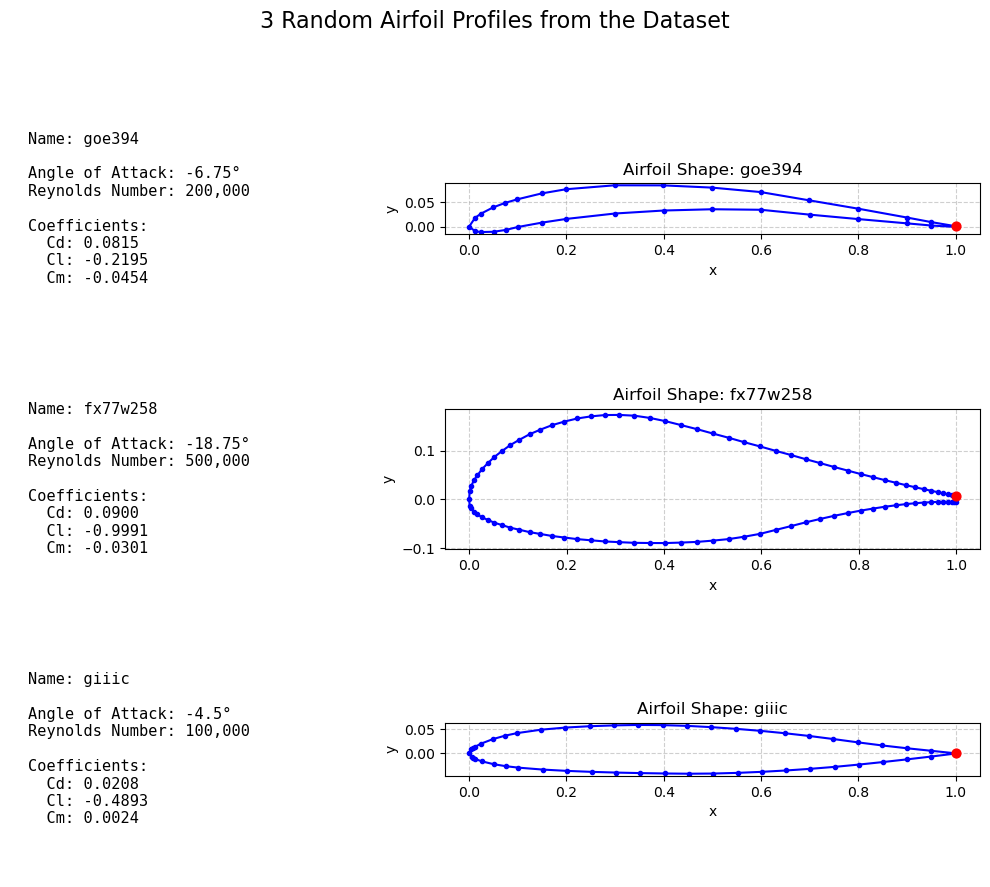

In [2]:
# Select 3 random entries from the airfoil database to show the data.
# sample(n=3) draws 3 random rows.
random_airfoils = df.sample(n=3)

# Helper function to parse coordinate strings.
def parse_coords(coord_string):
    """Converts a space-separated string of coordinates into a list of floats."""
    if isinstance(coord_string, str):
        return [float(c) for c in coord_string.strip().split()]
    return []


# We create a figure with 3 rows and 2 columns to visualise the database using Matplotlib.
# gridspec_kw allows setting different widths for the columns.
fig, axes = plt.subplots(3, 2, figsize=(10, 9), 
                         gridspec_kw={'width_ratios': [1, 1.5]})

fig.suptitle('3 Random Airfoil Profiles from the Dataset', fontsize=16)

# Iterate through the sampled airfoils and plot axes.
for i, (index, row) in enumerate(random_airfoils.iterrows()):
    ax_text = axes[i, 0]
    ax_text.axis('off') # Turn off the axis for the text cell.

    # Collect data for display.
    name = row['name']
    angle = row['angle']
    reynolds = row['reynolds']
    cd = row['cd']
    cl = row['cl']
    cm = row['cm']
    
    info_text = (
        f"Name: {name}\n\n"
        f"Angle of Attack: {angle}°\n"
        f"Reynolds Number: {reynolds:,.0f}\n\n"
        f"Coefficients:\n"
        f"  Cd: {cd:.4f}\n"
        f"  Cl: {cl:.4f}\n"
        f"  Cm: {cm:.4f}"
    )
    
    # Display the text about the airfoil in the cell.
    ax_text.text(0.05, 0.5, info_text, transform=ax_text.transAxes,
                 fontsize=11, verticalalignment='center', family='monospace')

    ax_plot = axes[i, 1]

    x_coords = parse_coords(row['x_coords'])
    y_coords = parse_coords(row['y_coords'])
    
    # Ploting the airfoil shape.
    ax_plot.plot(x_coords, y_coords, marker='o', markersize=3, linestyle='-', color='b')
    ax_plot.scatter([x_coords[0]], [y_coords[0]], color='red', s=40, zorder=5) # Highlight the start point.
    
    # Configuring the plot settings.
    ax_plot.set_title(f'Airfoil Shape: {name}')
    ax_plot.set_xlabel('x')
    ax_plot.set_ylabel('y')
    ax_plot.grid(True, linestyle='--', alpha=0.6)
    ax_plot.set_aspect('equal', adjustable='box')

# Adjusting the layout, rect leaves space for the main title.
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

# Data Preprocessing for the LSTM Model

In [ ]:
print("\n Starting Data Preprocessing for LSTM Model ")

# Parse all coordinate strings into lists of floats.
df['x_coords_list'] = df['x_coords'].apply(parse_coords)
df['y_coords_list'] = df['y_coords'].apply(parse_coords)

# Combine x and y coordinates into sequences of points for using LSTM.
df['points'] = [list(zip(x, y)) for x, y in zip(df['x_coords_list'], df['y_coords_list'])]

# Define features and targets.
features_scalar = ['angle', 'reynolds']
features_sequence = 'points'
all_targets = ['cl', 'cd', 'cm']

# Split data by unique airfoil names for robust validation.
airfoil_names = df['name'].unique()
train_names, test_names = train_test_split(airfoil_names, test_size=0.3, random_state=42)
val_names, test_names = train_test_split(test_names, test_size=0.5, random_state=42)

train_df = df[df['name'].isin(train_names)].copy()
val_df = df[df['name'].isin(val_names)].copy()
test_df = df[df['name'].isin(test_names)].copy()

print(f"Data split into: \n- Train: {len(train_df)} samples ({len(train_names)} unique airfoils)\n- Validation: {len(val_df)} samples ({len(val_names)} unique airfoils)\n- Test: {len(test_df)} samples ({len(test_names)} unique airfoils)")

# Normalize scalar features and targets using MinMaxScaler.
# Scalers are fitted ONLY on the training data to prevent data leakage.
scalar_feature_scaler = MinMaxScaler()
# We create a separate scaler for each potential target
target_scalers = {target: MinMaxScaler() for target in all_targets}

# Fit and transform training data.
train_df.loc[:, features_scalar] = scalar_feature_scaler.fit_transform(train_df[features_scalar])
val_df.loc[:, features_scalar] = scalar_feature_scaler.transform(val_df[features_scalar])
test_df.loc[:, features_scalar] = scalar_feature_scaler.transform(test_df[features_scalar])

for target in all_targets:
    train_df.loc[:, target] = target_scalers[target].fit_transform(train_df[[target]])
    val_df.loc[:, target] = target_scalers[target].transform(val_df[[target]])
    test_df.loc[:, target] = target_scalers[target].transform(test_df[[target]])

print("Scalar features and targets have been normalized.")

# PyTorch Dataset and DataLoader for LSTM

In [4]:
class AirfoilDataset(Dataset):
    """Custom PyTorch Dataset for airfoil data. Can handle single or multiple targets."""
    def __init__(self, dataframe, target_names=['cl', 'cd', 'cm']):
        self.dataframe = dataframe.reset_index(drop=True)
        self.sequences = [torch.tensor(seq, dtype=torch.float32) for seq in self.dataframe[features_sequence].values]
        self.other_features = torch.tensor(self.dataframe[features_scalar].values, dtype=torch.float32)
        self.targets = torch.tensor(self.dataframe[target_names].values, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        original_data_row = self.dataframe.iloc[idx]
        return self.sequences[idx], self.other_features[idx], self.targets[idx], original_data_row

def collate_fn(batch):
    """
    Custom collate function to handle variable length sequences.
    It pads sequences to the max length in a batch.
    """
    sequences, other_features, targets, original_data = zip(*batch)
    
    sequence_lengths = torch.tensor([len(seq) for seq in sequences])
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    other_features_tensor = torch.stack(other_features)
    targets_tensor = torch.stack(targets)
    
    return padded_sequences, sequence_lengths, other_features_tensor, targets_tensor, list(original_data)


# LSTM model

In [5]:
class AirfoilLSTMRegressor(nn.Module):
    def __init__(self, point_dim=2, lstm_hidden_dim=128, num_lstm_layers=2, 
                 fc_hidden_dim=64, output_dim=3, other_features_dim=2, dropout_prob=0.2):
        super(AirfoilLSTMRegressor, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=point_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=num_lstm_layers,
            batch_first=True,
            bidirectional=False
        )

        self.fc1 = nn.Linear(lstm_hidden_dim + other_features_dim, fc_hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(fc_hidden_dim, output_dim) # output_dim can be 1 or 3

    def forward(self, sequence_data, sequence_lengths, other_features):
        packed_input = pack_padded_sequence(
            sequence_data, 
            sequence_lengths.cpu(),
            batch_first=True, 
            enforce_sorted=False
        )
        
        packed_lstm_out, (h_n, _) = self.lstm(packed_input)
        shape_representation = h_n[-1,:,:]
        combined_features = torch.cat((shape_representation, other_features), dim=1)
        x = self.fc1(combined_features)
        x = self.relu(x)
        x = self.dropout(x)
        predictions = self.fc2(x)
        
        return predictions

# Model Training

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nStarting Model Training on {device}")
print(f"Selected Model Type: {MODEL_TYPE}")

BATCH_SIZE = 128
NUM_EPOCHS = 10 
trained_models = {}
all_losses = {}

# --- Single parameter ---
if MODEL_TYPE == 'single_output':
    for target_name in all_targets:
        print(f"\n--- Training model for target: {target_name.upper()} ---")

        train_dataset = AirfoilDataset(train_df, target_names=[target_name])
        val_dataset = AirfoilDataset(val_df, target_names=[target_name])
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

        model = AirfoilLSTMRegressor(output_dim=1, dropout_prob=0.3).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        train_losses, val_losses = [], []
        for epoch in range(NUM_EPOCHS):
            model.train()
            running_train_loss = 0.0
            pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} Training", leave=False)
            for sequences, lengths, others, targets_batch, _ in pbar:
                sequences, lengths, others, targets_batch = sequences.to(device), lengths.to(device), others.to(device), targets_batch.to(device)
                predictions = model(sequences, lengths, others)
                loss = criterion(predictions, targets_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

            epoch_train_loss = running_train_loss / len(train_loader)
            train_losses.append(epoch_train_loss)

            model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for sequences, lengths, others, targets_batch, _ in val_loader:
                    sequences, lengths, others, targets_batch = sequences.to(device), lengths.to(device), others.to(device), targets_batch.to(device)
                    predictions = model(sequences, lengths, others)
                    loss = criterion(predictions, targets_batch)
                    running_val_loss += loss.item()
            
            epoch_val_loss = running_val_loss / len(val_loader)
            val_losses.append(epoch_val_loss)
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {epoch_train_loss:.6f}, Validation Loss: {epoch_val_loss:.6f}")

        all_losses[target_name] = {'train': train_losses, 'val': val_losses}
        trained_models[target_name] = model
        torch.save(model.state_dict(), f'saved_model_lstm_{target_name}.pth')
        print(f"--- Training for {target_name.upper()} finished. ---")

elif MODEL_TYPE == 'multi_output':
    train_dataset = AirfoilDataset(train_df, target_names=all_targets)
    val_dataset = AirfoilDataset(val_df, target_names=all_targets)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True)

    model = AirfoilLSTMRegressor(output_dim=3, dropout_prob=0.3).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_train_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} Training", leave=False)
        for sequences, lengths, others, targets_batch, _ in pbar:
            sequences, lengths, others, targets_batch = sequences.to(device), lengths.to(device), others.to(device), targets_batch.to(device)
            predictions = model(sequences, lengths, others)
            loss = criterion(predictions, targets_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
        
        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for sequences, lengths, others, targets_batch, _ in val_loader:
                sequences, lengths, others, targets_batch = sequences.to(device), lengths.to(device), others.to(device), targets_batch.to(device)
                predictions = model(sequences, lengths, others)
                loss = criterion(predictions, targets_batch)
                running_val_loss += loss.item()

        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {epoch_train_loss:.6f}, Validation Loss: {epoch_val_loss:.6f}")

    trained_models['multi'] = model
    all_losses['multi'] = {'train': train_losses, 'val': val_losses}
    torch.save(model.state_dict(), 'saved_model_lstm_multi.pth')
    print(f"--- Multi-output model training finished. ---")

print("\nFull training process finished.")


Starting Model Training on cuda
Selected Model Type: single_output

--- Training model for target: CL ---


Epoch [1/10], Train Loss: 0.006999, Validation Loss: 0.001481


Epoch [2/10], Train Loss: 0.001904, Validation Loss: 0.001367


Epoch [3/10], Train Loss: 0.001696, Validation Loss: 0.001197


Epoch [4/10], Train Loss: 0.001612, Validation Loss: 0.001147


Epoch [5/10], Train Loss: 0.001569, Validation Loss: 0.001181


Epoch [6/10], Train Loss: 0.001535, Validation Loss: 0.001105


Epoch [7/10], Train Loss: 0.001503, Validation Loss: 0.001123


Epoch [8/10], Train Loss: 0.001482, Validation Loss: 0.001133


Epoch [9/10], Train Loss: 0.001452, Validation Loss: 0.000955


Epoch [10/10], Train Loss: 0.001439, Validation Loss: 0.000990
--- Training for CL finished. ---

--- Training model for target: CD ---


Epoch [1/10], Train Loss: 0.002260, Validation Loss: 0.001518


Epoch [2/10], Train Loss: 0.001496, Validation Loss: 0.001141


Epoch [3/10], Train Loss: 0.001285, Validation Loss: 0.001071


Epoch [4/10], Train Loss: 0.001158, Validation Loss: 0.001080


Epoch [5/10], Train Loss: 0.001072, Validation Loss: 0.000908


Epoch [6/10], Train Loss: 0.001021, Validation Loss: 0.000860


Epoch [7/10], Train Loss: 0.000967, Validation Loss: 0.000978


Epoch [8/10], Train Loss: 0.000934, Validation Loss: 0.000766


Epoch [9/10], Train Loss: 0.000906, Validation Loss: 0.000768


Epoch [10/10], Train Loss: 0.000884, Validation Loss: 0.000799
--- Training for CD finished. ---

--- Training model for target: CM ---


Epoch [1/10], Train Loss: 0.004985, Validation Loss: 0.001886


Epoch [2/10], Train Loss: 0.001771, Validation Loss: 0.001451


Epoch [3/10], Train Loss: 0.001526, Validation Loss: 0.001269


Epoch [4/10], Train Loss: 0.001406, Validation Loss: 0.001306


Epoch [5/10], Train Loss: 0.001324, Validation Loss: 0.001166


Epoch [6/10], Train Loss: 0.001275, Validation Loss: 0.001147


Epoch [7/10], Train Loss: 0.001237, Validation Loss: 0.001184


Epoch [8/10], Train Loss: 0.001199, Validation Loss: 0.001094


Epoch [9/10], Train Loss: 0.001173, Validation Loss: 0.001117


Epoch [10/10], Train Loss: 0.001155, Validation Loss: 0.001103
--- Training for CM finished. ---

Full training process finished.


# Saving model

In [12]:
torch.save(model, 'saved_model_LSTM.pth')

# Evaluating model on 10 random airfoils

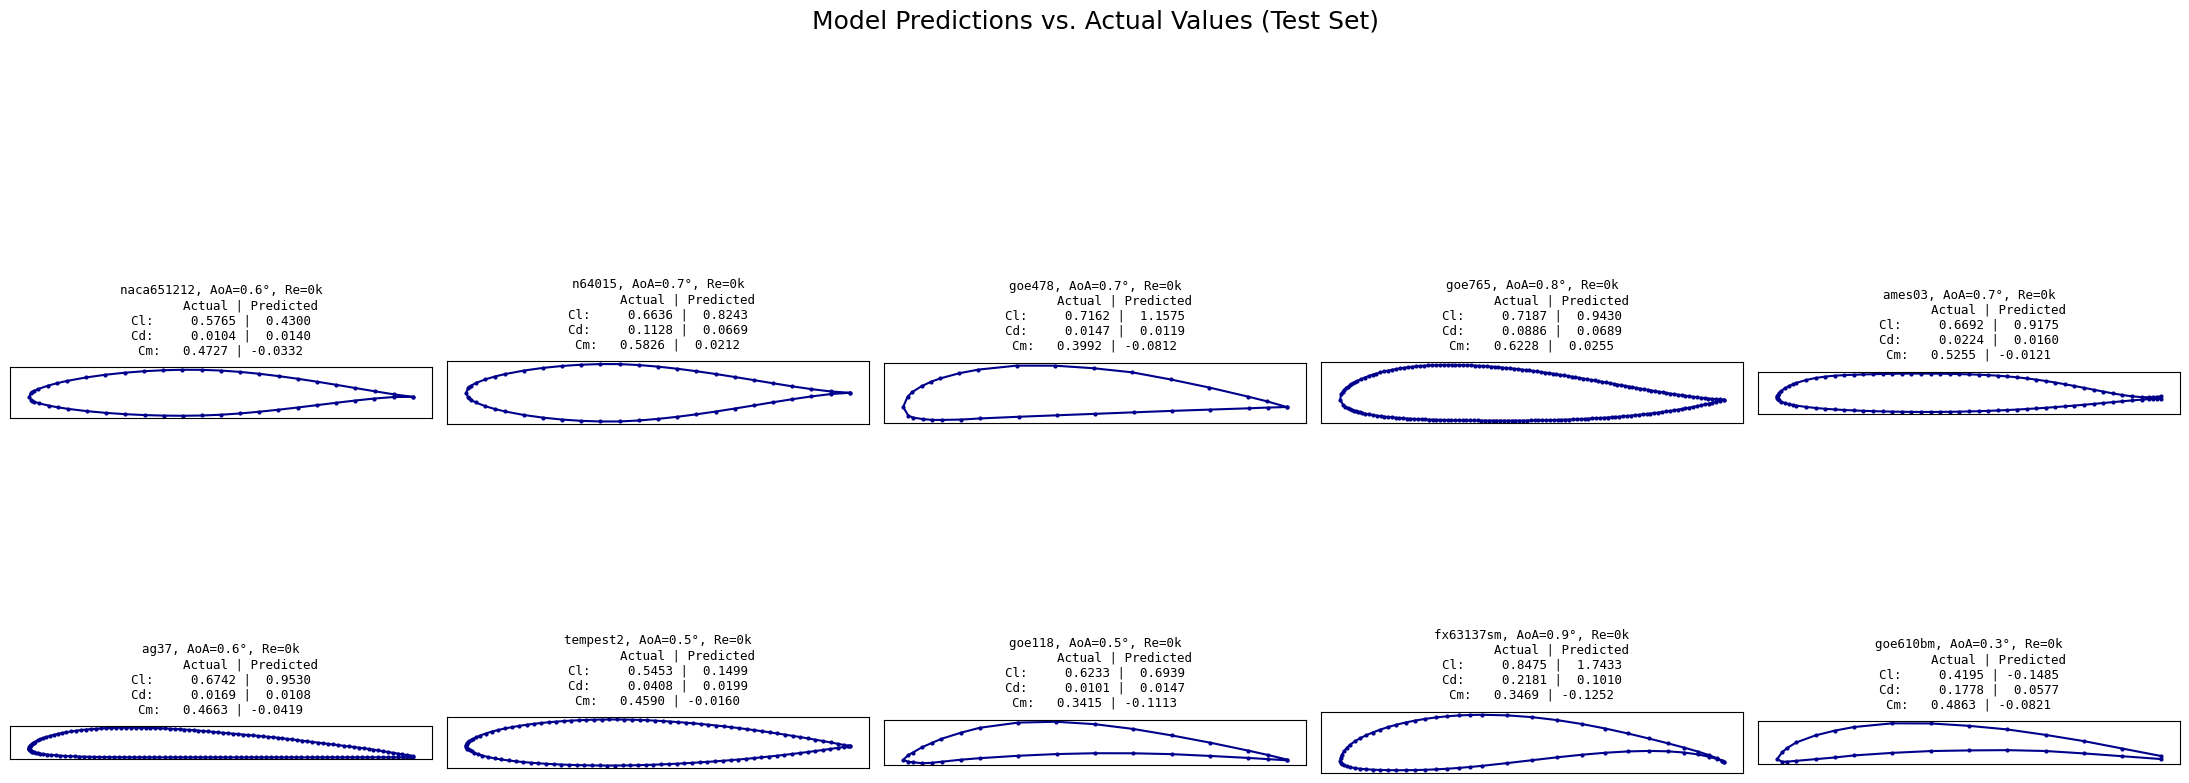

In [14]:
# Create a dataset for evaluation that provides all targets
eval_dataset = AirfoilDataset(test_df, target_names=all_targets)
test_loader_vis = DataLoader(eval_dataset, batch_size=10, shuffle=True, collate_fn=collate_fn)
sequences, lengths, others, targets_batch, original_data = next(iter(test_loader_vis))

sequences, lengths, others = sequences.to(device), lengths.to(device), others.to(device)

all_predictions = {}
with torch.no_grad():
    if MODEL_TYPE == 'single_output':
        for target_name, model in trained_models.items():
            model.eval()
            predictions_normalized = model(sequences, lengths, others)
            predictions_real = target_scalers[target_name].inverse_transform(predictions_normalized.cpu().numpy())
            all_predictions[target_name] = predictions_real
    else: # multi_output
        model = trained_models['multi']
        model.eval()
        predictions_normalized = model(sequences, lengths, others)
        predictions_real = target_scalers.inverse_transform(predictions_normalized.cpu().numpy())
        # Unpack predictions for each target
        all_predictions['cl'] = predictions_real[:, 0:1]
        all_predictions['cd'] = predictions_real[:, 1:2]
        all_predictions['cm'] = predictions_real[:, 2:3]


# Create a 2x5 grid for plotting
fig, axes = plt.subplots(2, 5, figsize=(22, 11))
axes = axes.flatten()
fig.suptitle('Model Predictions vs. Actual Values (Test Set)', fontsize=18)

for i in range(len(original_data)):
    ax = axes[i]
    orig_row = original_data[i]
    x_coords = orig_row['x_coords_list']
    y_coords = orig_row['y_coords_list']
    
    ax.plot(x_coords, y_coords, marker='.', markersize=4, linestyle='-', color='darkblue')
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linestyle='--', alpha=0.5)

    pred_cl = all_predictions['cl'][i][0]
    pred_cd = all_predictions['cd'][i][0]
    pred_cm = all_predictions['cm'][i][0]
    
    true_cl = orig_row['cl']
    true_cd = orig_row['cd']
    true_cm = orig_row['cm']
    
    title_text = (
        f"{orig_row['name']}, AoA={orig_row['angle']:.1f}°, Re={int(orig_row['reynolds']/1000)}k\n"
        f"        Actual | Predicted\n"
        f"Cl:    {true_cl: >7.4f} | {pred_cl: >7.4f}\n"
        f"Cd:    {true_cd: >7.4f} | {pred_cd: >7.4f}\n"
        f"Cm:  {true_cm: >7.4f} | {pred_cm: >7.4f}"
    )
    ax.set_title(title_text, fontsize=9, family='monospace', pad=10)
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(len(original_data), len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Showing training and validation loss based on LSTM model

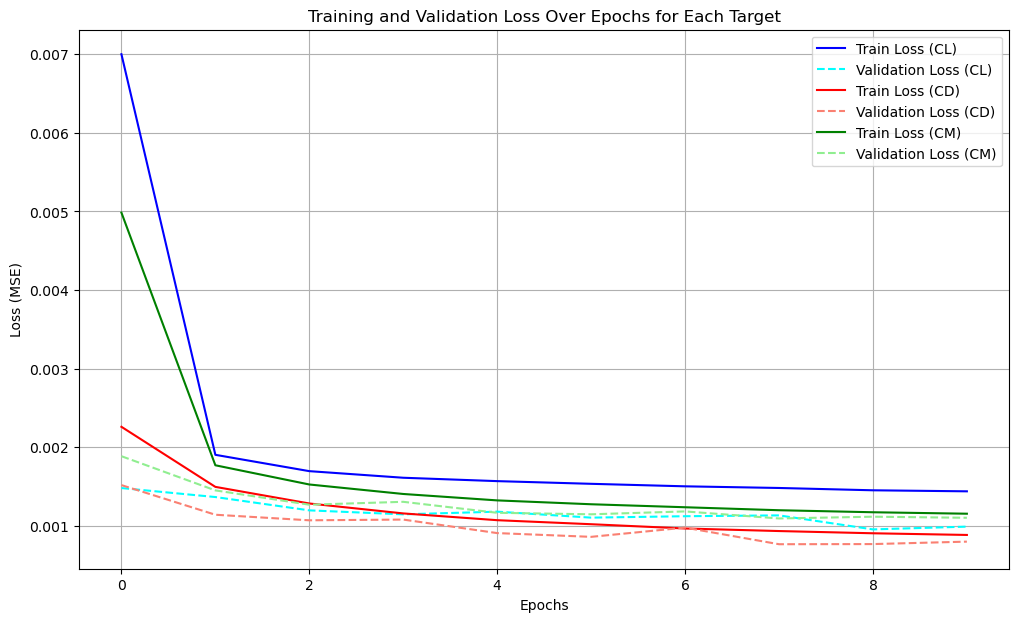

In [15]:
plt.figure(figsize=(12, 7))
colors = {'cl': ('blue', 'cyan'), 'cd': ('red', 'salmon'), 'cm': ('green', 'lightgreen')}

if MODEL_TYPE == 'single_output':
    for target_name, losses in all_losses.items():
        plt.plot(losses['train'], label=f'Train Loss ({target_name.upper()})', color=colors[target_name][0])
        plt.plot(losses['val'], label=f'Validation Loss ({target_name.upper()})', color=colors[target_name][1], linestyle='--')
    plt.title('Training and Validation Loss Over Epochs for Each Target')
else: # multi_output
    losses = all_losses['multi']
    plt.plot(losses['train'], label=f'Train Loss (Multi-Output)')
    plt.plot(losses['val'], label=f'Validation Loss (Multi-Output)', linestyle='--')
    plt.title('Training and Validation Loss Over Epochs for Multi-Output Model')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()